In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tifffile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops

# 1. Importing files

In [8]:
path_source = 'D:\sen12floods\sen12floods_s1_source'
path_labels = 'D:\sen12floods\sen12floods_s1_labels'

os.chdir(path_source)

# use loop to gather all files from directory
images = []
for root, curDir, files in os.walk(path_source):
    for file in files:
        images.append(os.path.join(root,file))


paths_source = []
for imgPath in images:
    if imgPath.endswith(".tif"):
        paths_source.append(imgPath) # gather all tif file paths

In [9]:
print(len(paths_source))

6663


In [10]:
os.chdir(path_labels)

# use loop to gather all json files from directory
labels = []
for root, curDir, files in os.walk(path_labels):
    for file in files:
        labels.append(os.path.join(root,file))
        
paths_labels = []
for labelPath in labels:
    if labelPath.endswith(".json"):
        paths_labels.append(labelPath) # gather all .json file paths

In [11]:
# extraxt id from 'source'

IDs=[]
for i in paths_source:
    source=os.path.split(os.path.split(i)[0])[1]
    m='_'.join(source.split('_')[3:])
    IDs.append(m)

idDict=dict(zip(paths_source, IDs))
print(len(paths_source))
print(len(IDs))
print(len(idDict))

6663
6663
6663


In [12]:
import json

# extraxt label from label

label=[]
key=[]
for i in paths_labels:
    with open(i) as f:
        data=json.load(f)
        label_id=data["id"]
        k=data["properties"]["FLOODING"]
        label.append(k)
        l='_'.join(label_id.split('_')[3:])
        key.append(l)

myDict=dict(zip(key,label))


In [13]:
flooding=[]
non_flooding=[]
labels=[]
# if date of source matches that of label, check label(0 or 1)
# if 0, store in non-flooding; if 1, store in flooding

for i in idDict:
    for j in myDict:
        if j==idDict[i]:
            labels.append(myDict[j])
            if myDict[j]=='True':
                flooding.append(i)
            else:
                non_flooding.append(i)
print(len(flooding))
print(len(non_flooding))
print(len(labels))

2063
4600
6663


# 2.Preprocessing

In [14]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.preprocessing import normalize
from PIL import Image

In [18]:
# append flooding images
# where they are currently resized to 256*256
# and normalised

ims_flooding = []
for im in flooding:
    image=tifffile.imread(im)
    image_resized=resize(image, (224, 224), anti_aliasing=True)
    ims_flooding.append(normalize(image_resized))


[[0.06799075 0.0554284  0.06955158 ... 0.12585127 0.08367883 0.09367573]
 [0.0418716  0.02803973 0.02871383 ... 0.1941917  0.16012381 0.07570352]
 [0.02421506 0.03098166 0.03071781 ... 0.12873046 0.27664897 0.12940715]
 ...
 [0.10632694 0.05136251 0.05807152 ... 0.11136657 0.10294164 0.0846642 ]
 [0.11846257 0.10212353 0.04311439 ... 0.10184517 0.10295903 0.0545542 ]
 [0.15550908 0.14383897 0.08537232 ... 0.06844955 0.07251912 0.04284699]]
(224, 224)


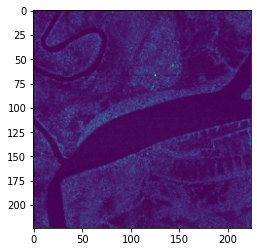

In [19]:
# # show image

# im0=ims_flooding[494]
# print(im0)
# print(im0.shape)
# plt.imshow(im0)

In [20]:

# append non_flooding images
# where they are currently resized to 256*256
# and normalised

ims_nflooding=[]
for im in non_flooding:
    image=tifffile.imread(im)
    image_resized=resize(image, (224, 224), anti_aliasing=True)
    ims_nflooding.append(normalize(image_resized))

In [21]:
# split into training (70%) and testing (30%):

train_sizeX = int(0.7 * len(ims_flooding))
test_sizeX = len(ims_flooding) - train_sizeX
print("Flooding dataset:\n   training set:", train_sizeX, "\n   testing set:", test_sizeX)

train_sizeY = int(0.7 * len(ims_nflooding))
test_sizeY = len(ims_nflooding) - train_sizeY
print("\nNon_flooding dataset:\n   training set:", train_sizeY, "\n   testing set:", test_sizeY)

Flooding dataset:
   training set: 1444 
   testing set: 619

Non_flooding dataset:
   training set: 3220 
   testing set: 1380


In [23]:
# gather all images to a list:
full_data=[]
full_data=ims_flooding + ims_nflooding

# all labels to a list:
targets=[]
label_train_f=[1]*len(ims_flooding)
label_train_nf=[0]*len(ims_nflooding)
targets=label_train_f + label_train_nf
print(len(full_data), len(targets))

6663 6663


In [407]:
# split into 70% training set and 30% testing set

data_train, data_test, target_train, target_test = train_test_split(
    full_data, targets, test_size=0.3, random_state=42)

In [412]:
# list to array for later use

cnn_data_train=np.array(data_train)
cnn_target_train=np.array(target_train)
print(cnn_data_train.shape,cnn_target_train.shape)

cnn_data_test=np.array(data_test)
cnn_target_test=np.array(target_test)
print(cnn_data_test.shape, cnn_target_test.shape)

(4664, 224, 224) (4664,)
(1999, 224, 224) (1999,)


In [89]:
# for feature extraction method glcm when building 3 supervised models, pixel values need to be int
from skimage.util import img_as_ubyte

ubyte = img_as_ubyte(data_train[0])
# print(ubyte.shape)
# plt.imshow(ubyte)

image_train=[]
for i in data_train:
    image_train.append(img_as_ubyte(i))

(224, 224)


# 3.1 Feature extraction for training set

In [1]:
# # function that calculates greycomatrix() and greycorprops() for angle0, 45,90 and 135

def feature_extract(img, label, props, dists=[4], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = graycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    
    textures = [] 
    # collects label and each glcm_properties
    # greycoprops compute the contrast for glcms with different angles 
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            textures.append(item)
    textures.append(label) 
    
    return textures

NameError: name 'np' is not defined

In [92]:
imlist = list(zip(image_train,target_train))

In [93]:
# 6 properties to be looked at
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

# call calc_glcm_agls
features = []
for img, label in imlist: 
    features.append(feature_extract(img, label, props=properties))
    
# other extract features including 'ocorrelation, contrast, correlation, cluster prominence,
# cluster shade, dissimilarity, energy, entropy, homogeneity, maximum probability, sum of squares (variance), sum
# average, sum variance, sum entropy, difference variance, difference variance, difference entropy, information
# measure of correlation, inverse difference normalized, inverse difference moment normalized.'

    

In [94]:
# alter column names to 'name'_'angle'
headers = []
angles = ['0', '45', '90','135']
for name in properties:
    for ang in angles:
        headers.append(name + "_" + ang)
        
headers.append("label")

In [95]:
# Create the pd DataFrame for features 
glcm_df = pd.DataFrame(features, columns = headers)

# get features
feature_df=glcm_df.iloc[:,:-1]

# display first row
display(feature_df.head(1))

# dataframe to array
feature_arr=np.array(feature_df)
print(feature_arr.shape)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135
0,6.477861,6.24031,6.02705,6.38052,0.251154,0.316024,0.378396,0.287518,0.168334,0.172205,...,71.554687,81.995803,0.002761,0.002828,0.002883,0.002781,0.052548,0.053181,0.053694,0.052739


(4664, 24)


# 3.2 Feature extraction for testing set

In [103]:
# to ints
image_test=[]
for i in data_test:
    image_test.append(img_as_ubyte(i))

# zip data and target
imlist_test = list(zip(image_test,target_test))

# feature extraction
features_test = []
for img, label in imlist_test: 
    features_test.append(feature_extract(img, label, props=properties))
    
# Create the pd DataFrame for features_test
glcm_df_test = pd.DataFrame(features_test, columns = headers)

# get features
feature_tst=glcm_df_test.iloc[:,:-1]

# display first row
display(feature_tst.head(1))

# dataframe to array
feature_arr_tst=np.array(feature_tst)
print(feature_arr_tst.shape)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135
0,6.407001,6.420057,6.394602,6.429127,0.317294,0.326523,0.331396,0.322631,0.163811,0.163145,...,77.511323,78.158125,0.002306,0.002296,0.002311,0.0023,0.048023,0.047917,0.048068,0.047954


(1999, 24)


# 4. Building the models and Evaluations

- visualisation of how diff. hyperparameters affect on validation set: check for overfitting and underfittng
- after deciding a range of hyperparameters, use gridsearchCV to find optimal hyperparameter values
- cross validate using trained model
- get accuracy for the trained model
- apply the model to test set
- generate classification_report

In [244]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, get_scorer
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve,learning_curve
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

# 4.1 SVM

# 1) First plot the influence of a single hyperparameter on the traing score and the validaton score to see if the estimator is overfitting or underfitting
- for kernels: 
    - a.rbf
    - b.linear
    - c.poly

In [1]:
# rename 
X_train = feature_arr
y_train = target_train

NameError: name 'feature_arr' is not defined

In [284]:
# function that plots score VS parameter value


def plot_valscore_vs_param(train_scores, val_scores,
                           title, xlabel, ylabel,
                           param_range):
    # means and stds
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, val_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show() 

In [451]:
# function that calls plot passing with different parameters

def plot_validation2(clf, parameter, param_range, _scoring):
    
    train_scores, valid_scores = validation_curve(
    clf, X_train, y_train, param_name=parameter, param_range=param_range, 
    cv=10, n_jobs=-1, scoring=_scoring)

    # plot validation score
    plot_valscore_vs_param(train_scores, valid_scores,
                          "Validation Curve with %s for %s"%(clf,parameter), 
                           parameter, 
                           "%s"%_scoring,
                           param_range)

a) Accuracy, precision and f1 with C values: 0.1, 1, 10, 100,1000 
and gamma values: 1, 0.1, 0.01, 0.001, 0.0001

In [2]:
# scores on traing and validation sets
C_range= [0.1, 1, 10, 100,1000]
gamma_range=[1, 0.1, 0.01, 0.001, 0.0001]

# kernel RBF
plot_validation2(SVC(kernel='rbf'), "C", C_range,'accuracy')
plot_validation2(SVC(kernel='rbf'), "gamma", gamma_range,'accuracy')

plot_validation2(SVC(kernel='rbf'), "C", C_range,'precision')
plot_validation2(SVC(kernel='rbf'), "gamma", gamma_range,'precision')

plot_validation2(SVC(kernel='rbf'), "C", C_range,'f1')
plot_validation2(SVC(kernel='rbf'), "gamma", gamma_range,'f1')

NameError: name 'plot_validation2' is not defined

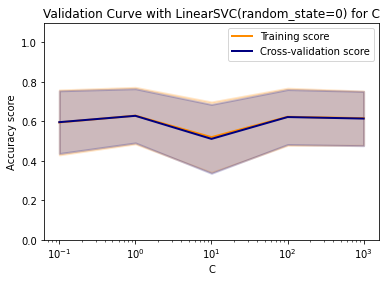

In [426]:
# kernel linear
plot_validation2(LinearSVC(random_state=0), "C", C_range,'accuracy')
plot_validation2(LinearSVC(random_state=0), "C", C_range,'precision')
plot_validation2(LinearSVC(random_state=0), "C", C_range,'f1')


# 2) Use GridSearchCV to perform hyperparameter tuning.

In [295]:
# find parameter values that optimize the score

def hp_tune(clf, param_grid):

    # use gridsearch to tune hyperparameters
    grid = HalvingGridSearchCV(clf, 
                               param_grid, 
                               refit=True, 
                               cv=10, 
                               n_jobs=-1, 
                               random_state=0) 

    # fit training data
    grid.fit(X_train, y_train)
    
    return grid

In [453]:
param_svc = {'C': [100, 1000],'gamma': [0.001, 0.0001],'kernel': ['rbf']}

# create SVC object
clf_svc = SVC(random_state=0)

# search for best parameter value
search_svc = hp_tune(clf_svc, param_svc)

# best paramenters 
print(search_svc.best_params_)

# mean scores
print(search_svc.best_score_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.7604241081729659


# 3) Cross Validation using retrained model

In [171]:
# funciton that return 4 scores in cross validation
# reference: https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/

def cross_validation(model, _X, _y, _cv):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True,
                               n_jobs=-1)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [211]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        plt.figure(figsize=(12,6))
        labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Fold 6", "Fold 7", "Fold 8","Fold 9","Fold 10"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2,train_data, 0.4, label='Training')
        plt.bar(X_axis+0.2,val_data, 0.4, label='Validation')
        plt.title(plot_title, fontsize=20)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.grid(True)
        plt.show()

In [439]:
# kernel rbf

estm_svc = SVC(C=1, gamma=0.001, kernel='rbf')

# cross validate acc
cv_score_rbf = cross_validation(estm_svc, X_train, y_train, 10)


In [434]:
# kernel linear

clf_svc_linear = LinearSVC(C=1, random_state=0)
cv_score_linear = cross_validation(clf_svc_linear, X_train, y_train, 10)

# 4) Visualisation: evaluation of training and validation sets 
 

In [445]:
def print_scores(cv_scores, param):
    print(cv_scores['Validation Accuracy scores'].mean())
    plot_result("%s"%param,
                "Accuracy",
                "Accuracy scores in 10 folds",
                cv_scores['Training Accuracy scores'],
                cv_scores['Validation Accuracy scores'])

    print(cv_scores['Validation Precision scores'].mean())
    plot_result("%s"%param,
                "Precision",
                "Precision in 10 folds",
                cv_scores['Training Precision scores'],
                cv_scores['Validation Precision scores'])

    print(cv_scores['Validation F1 scores'].mean())
    plot_result("%s"%param,
                "F1",
                "F1 in 10 folds",
                cv_scores['Training F1 scores'],
                cv_scores['Validation F1 scores'])

0.7412145830844308


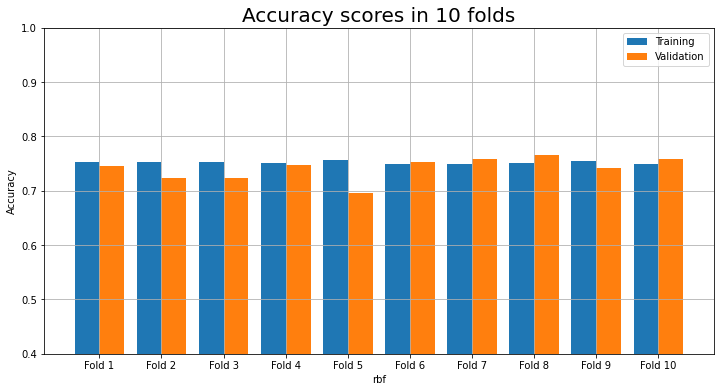

0.6213787787926656


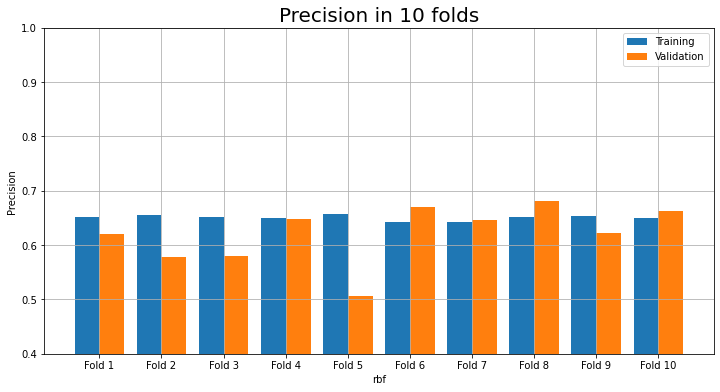

0.4809042468288565


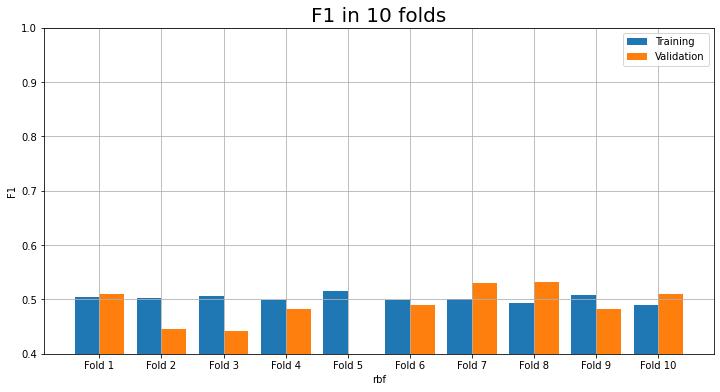

0.6282269255865676


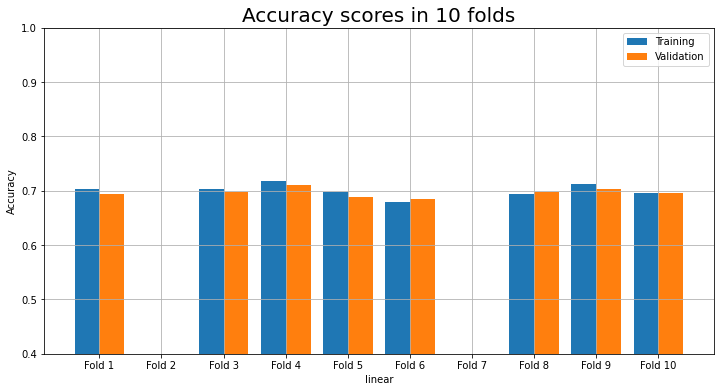

0.4769771291969363


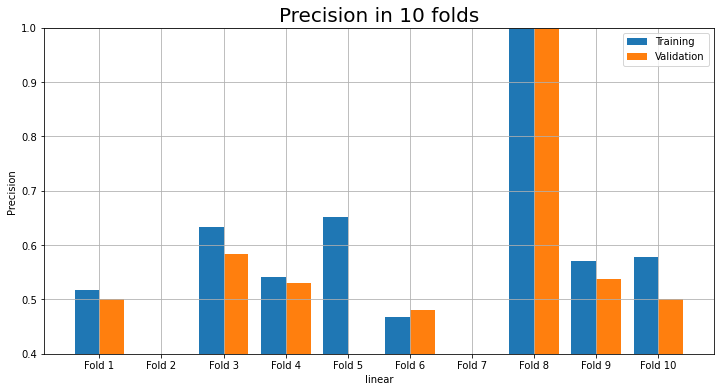

0.2762229614668863


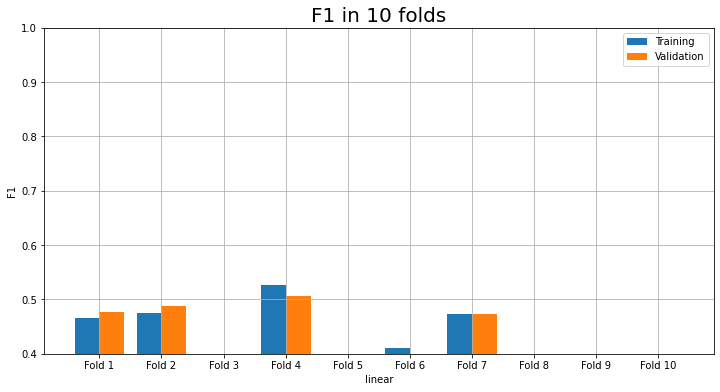

In [447]:
print_scores(cv_score_rbf, 'rbf')
print_scores(cv_score_linear, 'linear')

# 5) Apply retrained model to 30% test data 

In [304]:
# rename 
X_test = feature_arr_tst
y_test = target_test

# predict test set
y_pred_svc = grid.predict(X_test)

# genereate score report
cr_svc = classification_report(y_test, y_pred_svc)
print(cr_svc)

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1362
           1       0.66      0.54      0.59       637

    accuracy                           0.76      1999
   macro avg       0.73      0.70      0.71      1999
weighted avg       0.75      0.76      0.76      1999



# 4.2 KNN

Visualisation of hyperparameter tuning for leaf_size and n_neighbors

In [305]:
from sklearn.neighbors import KNeighborsClassifier

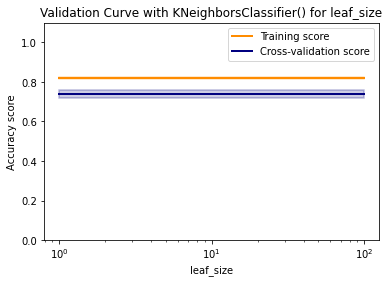

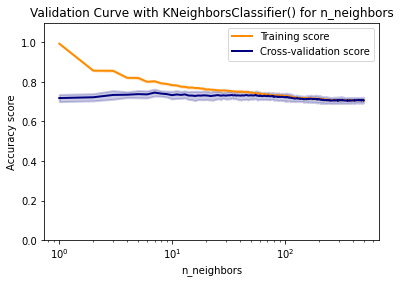

In [306]:
KNN=KNeighborsClassifier()

# leaf size
leaf_size= list(range(1,100))

# n_neighbors
nneighbor_size= list(range(1,500))

plot_validation(KNN, 'leaf_size', leaf_size)
plot_validation(KNN, 'n_neighbors', nneighbor_size)

Use GridSearch for hyperparametet tuning

In [333]:
param_knn = {'n_neighbors': list(range(90,150))}

# create SVC object
clf_knn = KNeighborsClassifier()

# search for best parameter value
search_knn = hp_tune(clf_knn, param_knn)

# best paramenters 
print(search_knn.best_params_)

# mean scores
print(search_knn.best_score_)

{'n_neighbors': 106}
0.7237068965517242


Evaluation of trained model using CV

In [334]:
estm_knn = KNeighborsClassifier(n_neighbors=106)

# cross validate acc
score_knn = cross_validation(estm_knn, X_train, y_train, 10)

0.722349762432107


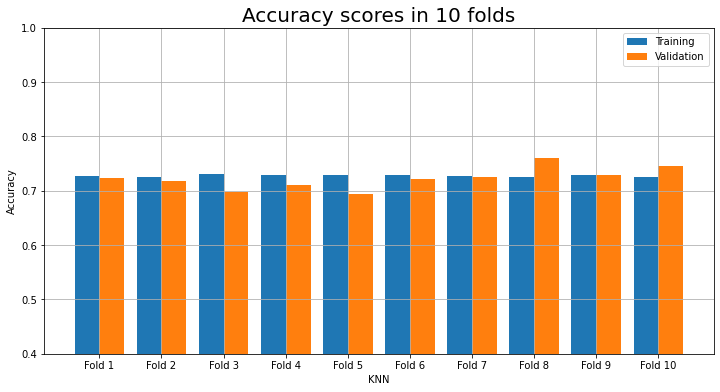

In [335]:
print(score_knn['Validation Accuracy scores'].mean())
plot_result("KNN",
            "Accuracy",
            "Accuracy scores in 10 folds",
            score_knn['Training Accuracy scores'],
            score_knn['Validation Accuracy scores'])

Evaluation using test data

In [337]:
# predict test set
estm_knn.fit(X_test, y_test)

y_pred_knn = estm_knn.predict(X_test)

# genereate score report
cr_knn = classification_report(y_test, y_pred_knn)
print(cr_knn)

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1362
           1       0.61      0.26      0.36       637

    accuracy                           0.71      1999
   macro avg       0.67      0.59      0.59      1999
weighted avg       0.69      0.71      0.67      1999



# 4.3 RF

Visualise how each parameter affects training score and validation score

In [377]:
from sklearn.ensemble import RandomForestClassifier

# define randomforeset classifier
rfc = RandomForestClassifier()

# define range of hyperparameters
rfc_params = {'max_depth': list(range(0, 100)), 
              'min_samples_split': list(range(2,10)),
              'max_leaf_nodes': list(range(0,100)),
              'min_samples_leaf': list(range(1,100)),
              'n_estimators': [10, 50, 100, 150],
              'max_samples': list(range(0,100)),
              'max_features': list(range(0,14))}

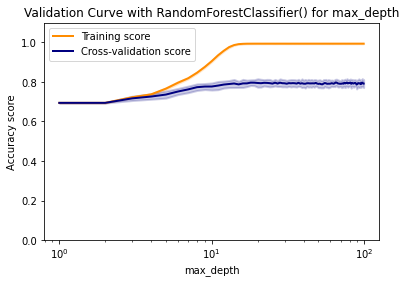

In [349]:
plot_validation(rfc, 'max_depth', rfc_params['max_depth'])

In [ ]:
plot_validation2(rfc, 'max_depth', rfc_params['max_depth'],'precision')
plot_validation2(rfc, 'max_depth', rfc_params['max_depth'],'f1')
plot_validation2(rfc, 'max_depth', rfc_params['max_depth'],'recall')

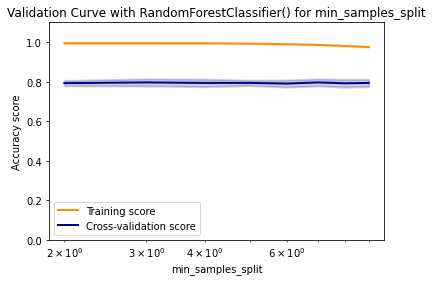

In [353]:
plot_validation(rfc, 'min_samples_split', rfc_params['min_samples_split'])

In [ ]:
plot_validation2(rfc, 'min_samples_split', rfc_params['min_samples_split'],'precision')
plot_validation2(rfc, 'min_samples_split', rfc_params['min_samples_split'],'f1')
plot_validation2(rfc, 'min_samples_split', rfc_params['min_samples_split'],'recall')

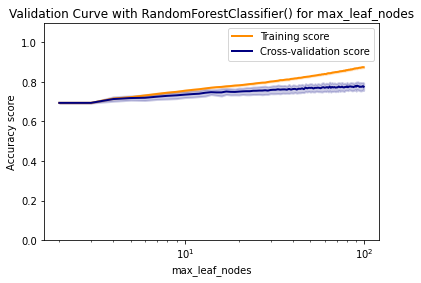

In [356]:
plot_validation(rfc, 'max_leaf_nodes', rfc_params['max_leaf_nodes'])

In [ ]:
plot_validation2(rfc, 'max_leaf_nodes', rfc_params['max_leaf_nodes'],'precision')
plot_validation2(rfc, 'max_leaf_nodes', rfc_params['max_leaf_nodes'],'f1')
plot_validation2(rfc, 'max_leaf_nodes', rfc_params['max_leaf_nodes'],'recall')

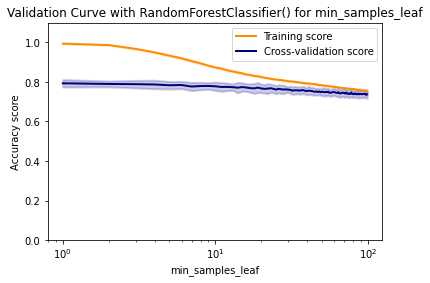

In [378]:
plot_validation(rfc, 'min_samples_leaf', rfc_params['min_samples_leaf'])

In [ ]:
plot_validation2(rfc, 'min_samples_leaf', rfc_params['min_samples_leaf'],'precision')
plot_validation2(rfc, 'min_samples_leaf', rfc_params['min_samples_leaf'],'f1')
plot_validation2(rfc, 'min_samples_leaf', rfc_params['min_samples_leaf'],'recall')

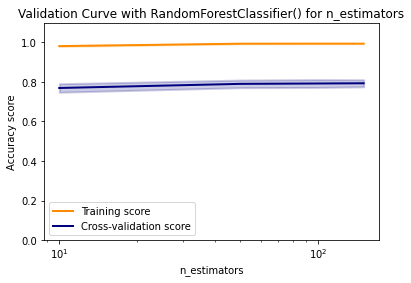

In [360]:
plot_validation(rfc, 'n_estimators', rfc_params['n_estimators'])

In [ ]:
plot_validation2(rfc, 'n_estimators', rfc_params['n_estimators'],'precision')
plot_validation2(rfc, 'n_estimators', rfc_params['n_estimators'],'f1')
plot_validation2(rfc, 'n_estimators', rfc_params['n_estimators'],'recall')

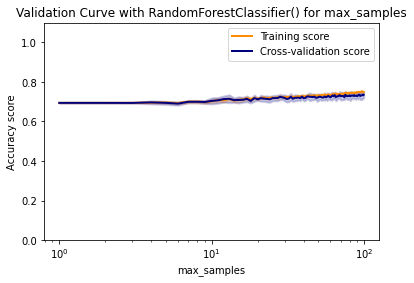

In [361]:
plot_validation(rfc, 'max_samples', rfc_params['max_samples'])

In [ ]:
plot_validation2(rfc, 'max_samples', rfc_params['max_samples'],'precision')
plot_validation2(rfc, 'max_samples', rfc_params['max_samples'],'f1')
plot_validation2(rfc, 'max_samples', rfc_params['max_samples'],'recall')

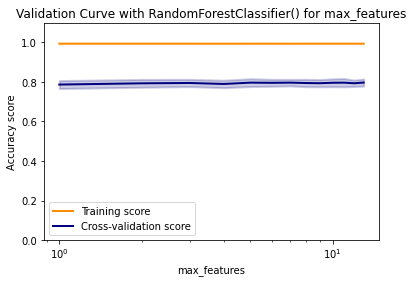

In [362]:
plot_validation(rfc, 'max_features', rfc_params['max_features'])

In [ ]:
plot_validation2(rfc, 'max_features', rfc_params['max_features'],'precision')
plot_validation2(rfc, 'max_features', rfc_params['max_features'],'f1')
plot_validation2(rfc, 'max_features', rfc_params['max_features'],'recall')

Hyperparameter tuning

In [385]:
# create a new parameter search grid
param_rf = {'max_leaf_nodes': list(range(10,20)),
              'min_samples_leaf': list(range(50,60)),
              'max_samples': [1]}

In [386]:
# search for best parameter value
search_rf = hp_tune(rfc, param_rf)

# best paramenters 
print(search_rf.best_params_)

# mean scores
print(search_rf.best_score_)

{'max_leaf_nodes': 12, 'max_samples': 1, 'min_samples_leaf': 54}
0.6946258369251862


0.6942542573820661


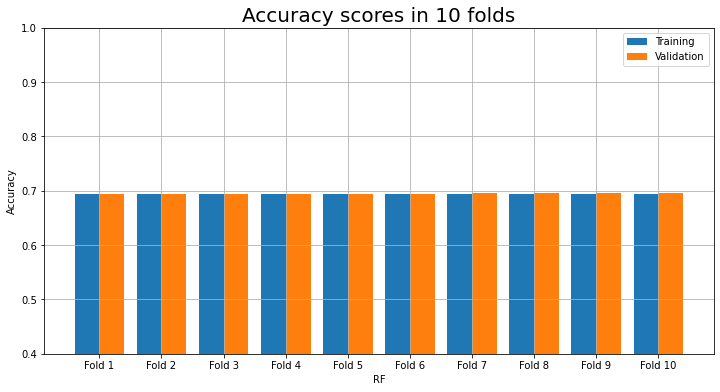

In [376]:
# apply optimised hyperparameters to the classifier

estm_rfc = RandomForestClassifier(max_leaf_nodes=12, max_samples=1,min_samples_leaf=54)

# cross validate acc
score_rf = cross_validation(estm_rfc, X_train, y_train, 10)

print(score_rf['Validation Accuracy scores'].mean())
plot_result("RF",
            "Accuracy",
            "Accuracy scores in 10 folds",
            score_rf['Training Accuracy scores'],
            score_rf['Validation Accuracy scores'])

Apply model to test data set

In [387]:
# predict test set
estm_rfc.fit(X_test, y_test)

y_pred_rf = estm_rfc.predict(X_test)

# genereate score report
cr_rf = classification_report(y_test, y_pred_rf)
print(cr_rf)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1362
           1       0.00      0.00      0.00       637

    accuracy                           0.68      1999
   macro avg       0.34      0.50      0.41      1999
weighted avg       0.46      0.68      0.55      1999



C:\Users\Hslastbow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hslastbow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hslastbow\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classifica

# 4.4 CNN

In [396]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [414]:
# add one dimention to training and testing sets
cnn_data_train=np.expand_dims(cnn_data_train, -1)
cnn_data_test=np.expand_dims(cnn_data_test, -1)
print(cnn_data_train.shape, cnn_data_test.shape)

(4664, 224, 224, 1) (1999, 224, 224, 1)


In [417]:
# function that builds the model with 2 hps:
#     number of layers
#     whether to use dropout layer
#     

def build_model(hp):
    inputs = keras.Input(shape=(224, 224, 1))
    
    # Model type can be MLP or CNN.
    model_type = hp.Choice("model_type", ["mlp", "cnn"])
    
    x = inputs
    if model_type == "mlp":
        x = layers.Flatten()(x)
        
        # Number of layers of the MLP is a hyperparameter.
        for i in range(hp.Int("mlp_layers", 1, 3)):
            # Number of units of each layer are
            # different hyperparameters with different names.
            output_node = layers.Dense(
                units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
            )(x)
    else:
        # Number of layers of the CNN is also a hyperparameter.
        for i in range(hp.Int("cnn_layers", 1, 3)):
            x = layers.Conv2D(
                hp.Int(f"filters_{i}", 32, 128, step=32),
                kernel_size=(3, 3),
                activation="relu",
            )(x)
            x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Flatten()(x)

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.5)(x)

    # The last layer contains 2 units,
    # which is the same as the number of classes.
    outputs = layers.Dense(units=2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam",
    )
    return model


In [419]:
hp = kt.HyperParameters()

hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = build_model(hp)
# Test if the model runs with our data.
model(cnn_data_train[:10])
# Print a summary of the model.
model.summary()

# Do the same for MLP model.
hp.values["model_type"] = "mlp"
model = build_model(hp)
model(cnn_data_train[:10])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 788546    
                                                                 
Total params: 788,866
Trainable params: 788,866
Non-trainable params: 0
_____________________________________________________

In [421]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=10,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_accuracy",
    # Set a directory to store the intermediate results.
    directory="/tmp/tb",
)

In [423]:
tuner.search(
    cnn_data_train,
    cnn_target_train,
    validation_split=0.3,
    epochs=2,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)


Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.7457143068313599

Best val_accuracy So Far: 0.8100000023841858
Total elapsed time: 00h 32m 08s
INFO:tensorflow:Oracle triggered exit


# 5 Evaluation